## Metric learning

In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 492.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl size=318664 sha256=dacb13a25b59ccd1ad9fe07a509fd1f866b469e14a00d52275e8ec0704985cda
  Stored in directory: /root/.cache/pip/wheels/2d/d1/15/8a2f0086896d156654a843fff4bdbeaf621cdd10310a0daad2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.2/658.2 kB 17.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.7/317.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-non

In [2]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/kaggle/input/vkcup1/train_mod_v3.csv')
df

,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test.to_csv('test_mod_v3.csv')
del df_test 
#del df

In [4]:
N_TOTAL = max(df['u'].max(), df['v'].max()) + 1
df

,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [5]:
def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = min(len(target), k) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


In [6]:
df_test = pd.read_csv('test_mod_v3.csv')

target_arr = [[] for _ in range(N_TOTAL)]

for i in range(df_test.shape[0]):
    u, v = df_test['u'].iloc[i], df_test['v'].iloc[i]
    if u >= N_TOTAL or v >= N_TOTAL:
        continue
    target_arr[u].append(v)
    target_arr[v].append(u)
del df_test

In [7]:
import networkx as nx
import random
from networkx import ego_graph
from tqdm.auto import trange


class GraphSampler:
    def __init__(self, df, N_PARTS, number_same_graph = 10000, number_same_graph2 = 70000):
        self.df = df
        self.N_PARTS = N_PARTS
        self.number_same_graph = number_same_graph
        self.number_same_graph2 = number_same_graph2
        self.DF_TRAIN = []
        self.iteration = 0
        df1 = df
        for i in range(N_PARTS):
            df1, df_cur = train_test_split(df1, test_size = int(len(self.df) / N_PARTS), random_state=42)
            self.DF_TRAIN.append(df_cur)
        self.cur_graph = nx.Graph()

        self.edges_set = [set() for i in range(N_TOTAL)]
        for i in trange(self.df.shape[0]):
            u, v = self.df['u'].iloc[i], self.df['v'].iloc[i]
            self.edges_set[u].add(v)
            self.edges_set[v].add(u)

    def __getitem__(self, index):
        del self.cur_graph
        self.cur_graph = nx.Graph()
        self.cur_graph.add_nodes_from(list(range(N_TOTAL)))
        self.cur_graph.add_edges_from(self.DF_TRAIN[index][['u', 'v']].values)


    def get_random_subgraph(self, size_graph):
        mask = np.random.choice(self.indices, size=size_graph)
        return self.cur_graph.subgraph(self.indices[mask])

    def get_random_connected(self, thr=60):
        v0 = random.randint(0, N_TOTAL - 1)
        g0 = ego_graph(self.cur_graph, n=v0, radius=1)
        if len(g0.nodes) < thr:
            g0 = ego_graph(self.cur_graph, n=v0, radius=2)
        return g0

    def generate_random_graph(self, p_connected, size_graph, thr=60):
        if self.iteration % self.number_same_graph == 0:
            self.__getitem__(random.randint(0, self.N_PARTS - 1))
        self.iteration += 1
        if random.random() < p_connected:
            return self.get_random_connected(thr)
        else:
            return self.get_random_subgraph(size_graph)

    @torch.no_grad()
    def inference_model(self, model, num_samples_big, degree_threshold, diameter, K, lim2evaluate = None):
        sum_apk, cnt_apk = 0, 1e-9
        n_vertexes = lim2evaluate if lim2evaluate is not None else N_TOTAL
        for i in trange(n_vertexes):
            if len(target_arr[i]) == 0:
                continue
            if self.iteration % self.number_same_graph2 == 0:
                self.__getitem__(random.randint(0, self.N_PARTS - 1))
            self.iteration += 1
            recommendations = []
            if len(self.edges_set[i]) >= degree_threshold:
                g0 = ego_graph(self.cur_graph, n=i, radius=diameter)
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum((output[id2pos[v0]] - output[id2pos[v1]]) ** 2).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[:K]
                recommendations = [ind for _, ind in pred_logits]
            else:
                g0 = nx.Graph()
                g0.add_node(i)
                for _ in range(num_samples_big):
                     g0.add_node(random.randint(0, N_TOTAL - 1))
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum((output[id2pos[v0]] - output[id2pos[v1]]) ** 2).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[:K]
                recommendations = [ind for _, ind in pred_logits]
            
            sum_apk += apk(recommendations, target_arr[i], K)
            cnt_apk += 1
        return sum_apk / cnt_apk




In [8]:
graph_manager = GraphSampler(df_train, 40)


  0%|          | 0/13396072 [00:00<?, ?it/s]

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device

device(type='cpu')

In [10]:
import torch 
import torch.nn as nn
import torch_geometric as tg
from torch_geometric.utils.convert import to_networkx, from_networkx

class GCNModel(nn.Module):
    def __init__(self, num_vertexes, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_vertexes, embedding_dim)
        self.layers = nn.ModuleList([])
        self.layers.append(tg.nn.GCNConv(embedding_dim, hidden_dim))
        self.relu = nn.ReLU()
        for i in range(num_layers):
            self.layers.append(tg.nn.GCNConv(hidden_dim, hidden_dim))
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, graph):
        input_data = from_networkx(graph)
        input_vertexes = torch.tensor(list(graph.nodes)).to(device)
        hidden = self.embedding(input_vertexes)
        for layer in self.layers:
            hidden = layer(hidden, input_data.edge_index.to(device))
            hidden = self.relu(hidden)
        return self.last(hidden)

In [11]:
n_layers = 4

model = GCNModel(N_TOTAL, 16, 64, n_layers).to(device)
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)

In [12]:
from networkx import ego_graph
import networkx as nx
from tqdm.auto import trange

iterations = 150000
save_every = 100
evaluate_every = 700
lim2evaluate = 15000


pbar = trange(iterations)

values_loss, values_metric = [],  []

for iteration in pbar:
    optimizer.zero_grad()
    input_graph = graph_manager.generate_random_graph(1, 60)
    vertexes = list(input_graph.nodes)
    id2pos = {val: pos for pos, val in enumerate(vertexes)}
    
    if len(input_graph.edges) == 0:
        continue
    for edge in input_graph.edges:
        break
    test_edges = [edge]
    input_graph.remove_edges_from(test_edges)

    output = model(input_graph)
    v0 = test_edges[0][0]
    v1 = test_edges[0][1]
    v2 = -1
    for i in input_graph:
        if (v0, i) not in graph_manager.edges_set:
            v2 = i
            break
    if v2 == -1:
        continue

    pred_logit = output[id2pos[v0]].unsqueeze(0)
    positive_logit = output[id2pos[v1]].unsqueeze(0)
    negative_logit = output[id2pos[v2]].unsqueeze(0)

    loss = criterion(pred_logit, positive_logit, negative_logit) 
    pbar.set_description(f"train loss: {loss.item()}")
    loss.backward()
    values_loss.append(loss.item())
    optimizer.step()

    if iteration % save_every == save_every - 1:
        torch.save(model, "start_model.pt")
    if iteration % evaluate_every == evaluate_every - 1:
        values_metric.append(graph_manager.inference_model(model, 50, 20, 3, 30, lim2evaluate))

  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

In [13]:
torch.save(model, f'out_{n_layers}.pt')

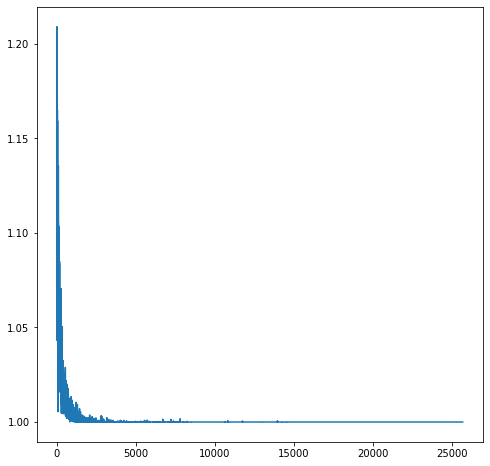

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))
plt.plot(np.arange(0, len(values_loss)), values_loss);


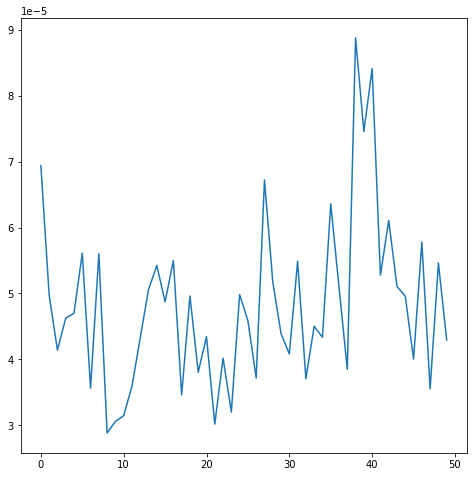

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))
plt.plot(np.arange(0, len(values_metric)), values_metric);


In [16]:
import pickle
with open("metrics.txt", 'wb') as f:
    pickle.dump(values_metric, f)

with open("losses.txt", 'wb') as f:
    pickle.dump(values_loss, f)
